# Final Project: Looking for Exoplanets
Collin Sinclair

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle
from astropy.io import ascii
from scipy.optimize import curve_fit

I have cleaned the data files for the three systems I will be analyzing by deleting their titles and dash rows and renaming the column headers. Otherwise the data has been untouched. `system_1` corresponds to `UnknownPlanetStar1`, `system_2` to `UnknownPlanetStar2`, and `system_3` to `Zach Star 1 Data`.

In [2]:
# Import the data
system_1 = ascii.read('system_1.txt')
system_2 = ascii.read('system_2.txt')
system_3 = ascii.read('system_3.txt')

In [3]:
# fit_sin function copied from user on Stack Overflow - needed to have functional form of LSP model
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return fitfunc

## System 1

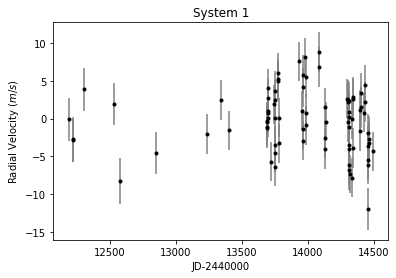

In [4]:
# Plot the raw data
plt.errorbar(system_1['date'], system_1['vel'], system_1['unc'], fmt='.k', ecolor='grey')
plt.xlabel('JD-2440000')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 1')
plt.savefig('sys_1/sys_1.pdf')

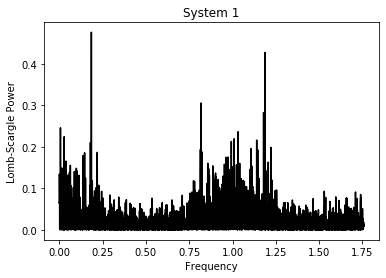

In [5]:
# Compute the Lomb-Scargle periodogram of the data and plot
sys_1_ls = LombScargle(system_1['date'], system_1['vel'], system_1['unc'])
sys_1_freq, sys_1_power = sys_1_ls.autopower(nyquist_factor=100)
plt.plot(sys_1_freq, sys_1_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 1')
plt.savefig('sys_1/sys_1_ls.pdf')

In [6]:
# Determine the false alarm probability of the periodogram maximum
sys_1_false_alarm_prob = sys_1_ls.false_alarm_probability(sys_1_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_1_power.max(), sys_1_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.48 or above approximately 0.0% of the time.


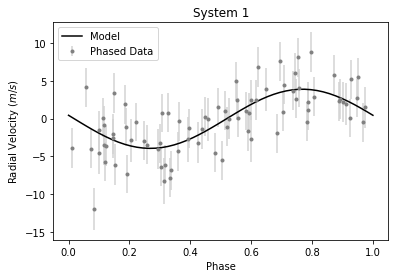

In [7]:
# Compute the best fit sinusoid
sys_1_period_days = 1 / sys_1_freq
sys_1_best_period = sys_1_period_days[np.argmax(sys_1_power)]
sys_1_phase = (system_1['date'] / sys_1_best_period) % 1
plt.errorbar(sys_1_phase, system_1['vel'], system_1['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_1_phase_model = np.linspace(0, 1)
sys_1_best_frequency = sys_1_freq[np.argmax(sys_1_power)]
sys_1_vel_model = sys_1_ls.model(sys_1_phase_model / sys_1_best_frequency, sys_1_best_frequency)
plt.plot(sys_1_phase_model, sys_1_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 1')
plt.legend()
plt.savefig('sys_1/sys_1_phase_plot.pdf')

In [8]:
print('The best period for System 1 is {:.2f} days.'.format(sys_1_best_period))

The best period for System 1 is 5.40 days.


### Second Pass - System 1
Now that I've determined a period for the system, I must remove it from the data to check a) if I got the period right and b) to check if there are more planets orbiting the star in question.

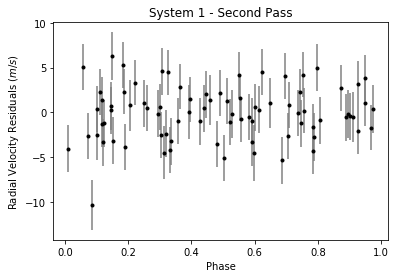

In [9]:
# Compute residuals
sys_1_fit = fit_sin(sys_1_phase_model, sys_1_vel_model)
sys_1_residuals = system_1['vel'] - sys_1_fit(sys_1_phase.value)
plt.errorbar(sys_1_phase, sys_1_residuals, system_1['unc'], fmt='.k', ecolor='grey')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity Residuals ($m/s$)')
plt.title('System 1 - Second Pass')
plt.savefig('sys_1/sys_1_2.pdf')

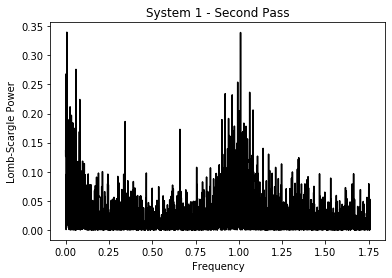

In [10]:
# Compute the Lomb-Scargle periodogram of the residuals and plot
sys_1_2_ls = LombScargle(system_1['date'], sys_1_residuals, system_1['unc'])
sys_1_2_freq, sys_1_2_power = sys_1_2_ls.autopower(nyquist_factor=100)
plt.plot(sys_1_2_freq, sys_1_2_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 1 - Second Pass')
plt.savefig('sys_1/sys_1_2_ls.pdf')

In [11]:
# Determine the false alarm probability of the second periodogram maximum
sys_1_2_false_alarm_prob = sys_1_2_ls.false_alarm_probability(sys_1_2_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_1_2_power.max(), sys_1_2_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.34 or above approximately 0.0% of the time.


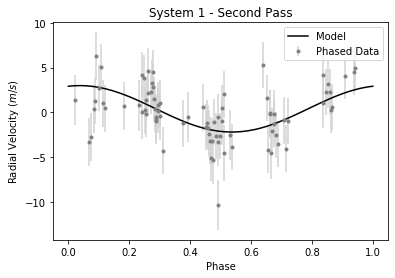

In [12]:
# Compute the best fit sinusoid of the residual
sys_1_2_period_days = 1 / sys_1_2_freq
sys_1_2_best_period = sys_1_2_period_days[np.argmax(sys_1_2_power)]
sys_1_2_phase = (system_1['date'] / sys_1_2_best_period) % 1
plt.errorbar(sys_1_2_phase, sys_1_residuals, system_1['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_1_2_phase_model = np.linspace(0, 1)
sys_1_2_best_frequency = sys_1_2_freq[np.argmax(sys_1_2_power)]
sys_1_2_vel_model = sys_1_2_ls.model(sys_1_2_phase_model / sys_1_2_best_frequency, sys_1_2_best_frequency)
plt.plot(sys_1_2_phase_model, sys_1_2_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 1 - Second Pass')
plt.legend()
plt.savefig('sys_1/sys_1_2_phase_plot.pdf')

In [13]:
print('The second best period for System 1 is {:.2f} days.'.format(sys_1_2_best_period))

The second best period for System 1 is 146.80 days.


## System 2

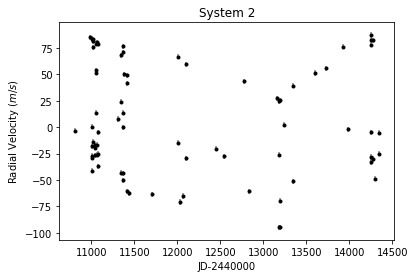

In [14]:
# Plot the raw data
plt.errorbar(system_2['date'], system_2['vel'], system_2['unc'], fmt='.k', ecolor='grey')
plt.xlabel('JD-2440000')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 2')
plt.savefig('sys_2/sys_2.pdf')

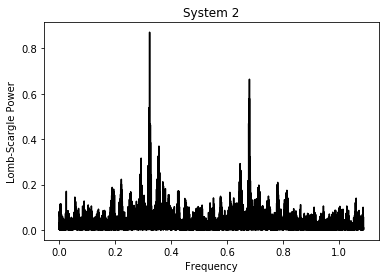

In [15]:
# Compute the Lomb-Scargle periodogram of the data and plot
sys_2_ls = LombScargle(system_2['date'], system_2['vel'], system_2['unc'])
sys_2_freq, sys_2_power = sys_2_ls.autopower(nyquist_factor=100)
plt.plot(sys_2_freq, sys_2_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 2')
plt.savefig('sys_2/sys_2_ls.pdf')

In [16]:
# Determine the false alarm probability of the periodogram maximum
sys_2_false_alarm_prob = sys_2_ls.false_alarm_probability(sys_2_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_2_power.max(), sys_2_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.87 or above approximately 0.0% of the time.


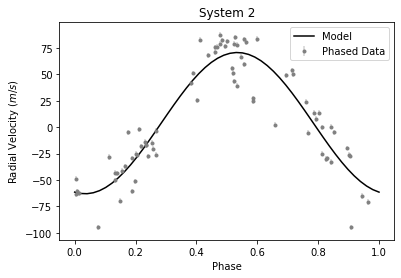

In [17]:
# Compute the best fit sinusoid
sys_2_period_days = 1. / sys_2_freq
sys_2_best_period = sys_2_period_days[np.argmax(sys_2_power)]
sys_2_phase = (system_2['date'] / sys_2_best_period) % 1
plt.errorbar(sys_2_phase, system_2['vel'], system_2['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_2_phase_model = np.linspace(0, 1)
sys_2_best_frequency = sys_2_freq[np.argmax(sys_2_power)]
sys_2_vel_model = sys_2_ls.model(sys_2_phase_model / sys_2_best_frequency, sys_2_best_frequency)
plt.plot(sys_2_phase_model, sys_2_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 2')
plt.legend()
plt.savefig('sys_2/sys_2_phase_plot.pdf')

In [18]:
print('The best period for System 2 is {:.2f} days.'.format(sys_2_best_period))

The best period for System 2 is 3.10 days.


### Second Pass - System 2

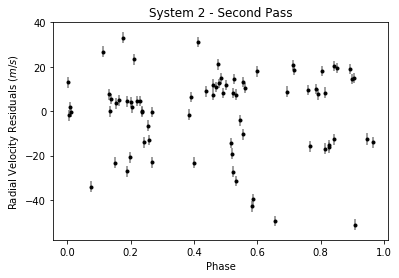

In [19]:
# Compute residuals
sys_2_fit = fit_sin(sys_2_phase_model, sys_2_vel_model)
sys_2_residuals = system_2['vel'] - sys_2_fit(sys_2_phase.value)
plt.errorbar(sys_2_phase, sys_2_residuals, system_2['unc'], fmt='.k', ecolor='grey')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity Residuals ($m/s$)')
plt.title('System 2 - Second Pass')
plt.savefig('sys_2/sys_2_2.pdf')

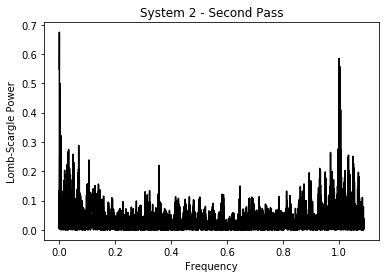

In [20]:
# Compute the Lomb-Scargle periodogram of the residuals and plot
sys_2_2_ls = LombScargle(system_2['date'], sys_2_residuals, system_2['unc'])
sys_2_2_freq, sys_2_2_power = sys_2_2_ls.autopower(nyquist_factor=100)
plt.plot(sys_2_2_freq, sys_2_2_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 2 - Second Pass')
plt.savefig('sys_2/sys_2_2_ls.pdf')

In [21]:
# Determine the false alarm probability of the second periodogram maximum
sys_2_2_false_alarm_prob = sys_2_2_ls.false_alarm_probability(sys_2_2_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_2_2_power.max(), sys_2_2_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.67 or above approximately 0.0% of the time.


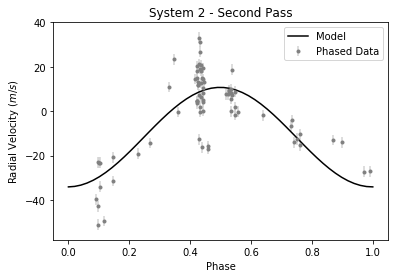

In [22]:
# Compute the best fit sinusoid of the residual
sys_2_2_period_days = 1 / sys_2_2_freq
sys_2_2_best_period = sys_2_2_period_days[np.argmax(sys_2_2_power)]
sys_2_2_phase = (system_2['date'] / sys_2_2_best_period) % 1
plt.errorbar(sys_2_2_phase, sys_2_residuals, system_2['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_2_2_phase_model = np.linspace(0, 1)
sys_2_2_best_frequency = sys_2_2_freq[np.argmax(sys_2_2_power)]
sys_2_2_vel_model = sys_2_2_ls.model(sys_2_2_phase_model / sys_2_2_best_frequency, sys_2_2_best_frequency)
plt.plot(sys_2_2_phase_model, sys_2_2_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 2 - Second Pass')
plt.legend()
plt.savefig('sys_2/sys_2_2_phase_plot.pdf')

In [23]:
print('The second best period for System 2 is {:.2f} days.'.format(sys_2_2_best_period))

The second best period for System 2 is 3216.49 days.


### Third Pass - System 2

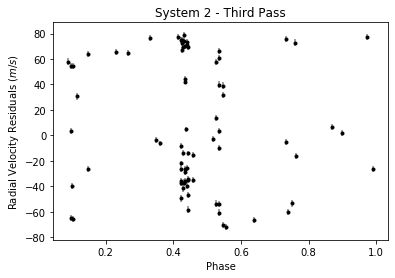

In [24]:
# Compute residuals
sys_2_2_fit = fit_sin(sys_2_2_phase_model, sys_2_2_vel_model)
sys_2_2_residuals = system_2['vel'] - sys_2_2_fit(sys_2_2_phase.value)
plt.errorbar(sys_2_2_phase, sys_2_2_residuals, system_2['unc'], fmt='.k', ecolor='grey')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity Residuals ($m/s$)')
plt.title('System 2 - Third Pass')
plt.savefig('sys_2/sys_2_3.pdf')

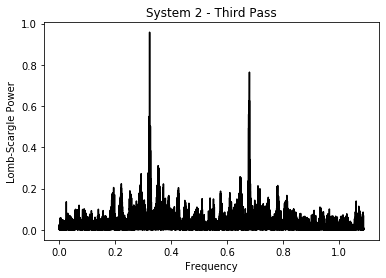

In [25]:
# Compute the Lomb-Scargle periodogram of the residuals and plot
sys_2_3_ls = LombScargle(system_2['date'], sys_2_2_residuals, system_2['unc'])
sys_2_3_freq, sys_2_3_power = sys_2_3_ls.autopower(nyquist_factor=100)
plt.plot(sys_2_3_freq, sys_2_3_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 2 - Third Pass')
plt.savefig('sys_2/sys_2_3_ls.pdf')

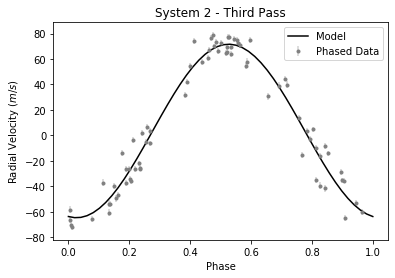

In [26]:
# Compute the best fit sinusoid of the residual
sys_2_3_period_days = 1 / sys_2_3_freq
sys_2_3_best_period = sys_2_3_period_days[np.argmax(sys_2_3_power)]
sys_2_3_phase = (system_2['date'] / sys_2_3_best_period) % 1
plt.errorbar(sys_2_3_phase, sys_2_2_residuals, system_2['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_2_3_phase_model = np.linspace(0, 1)
sys_2_3_best_frequency = sys_2_3_freq[np.argmax(sys_2_3_power)]
sys_2_3_vel_model = sys_2_3_ls.model(sys_2_3_phase_model / sys_2_3_best_frequency, sys_2_3_best_frequency)
plt.plot(sys_2_3_phase_model, sys_2_3_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 2 - Third Pass')
plt.legend()
plt.savefig('sys_2/sys_2_3_phase_plot.pdf')

In [27]:
print('The third best period for System 2 is {:.2f} days.'.format(sys_2_3_best_period))

The third best period for System 2 is 3.10 days.


## System 3

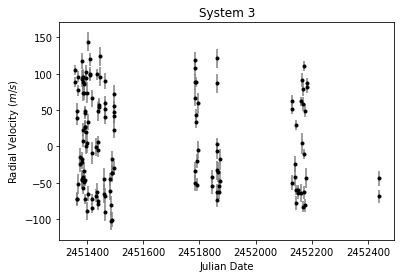

In [28]:
# Plot the raw data
plt.errorbar(system_3['date'], system_3['vel'], system_3['unc'], fmt='k.', ecolor='grey')
plt.xlabel('Julian Date')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 3')
plt.savefig('sys_3/sys_3.pdf')

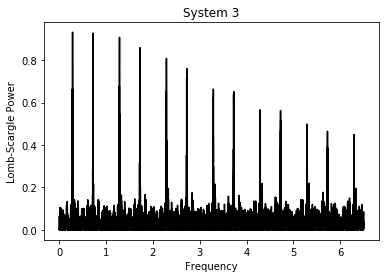

In [29]:
# Compute the Lomb-Scargle periodogram of the data and plot
sys_3_ls = LombScargle(system_3['date'], system_3['vel'], system_3['unc'])
sys_3_freq, sys_3_power = sys_3_ls.autopower(nyquist_factor=100)
plt.plot(sys_3_freq, sys_3_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 3')
plt.savefig('sys_3/sys_3_ls.pdf')

In [30]:
# Determine the false alarm probability of the periodogram maximum
sys_3_false_alarm_prob = sys_3_ls.false_alarm_probability(sys_3_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_3_power.max(), sys_3_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.93 or above approximately 0.0% of the time.


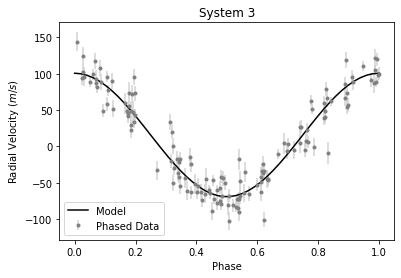

In [31]:
# Compute the best fit sinusoid
sys_3_period_days = 1. / sys_3_freq
sys_3_best_period = sys_3_period_days[np.argmax(sys_3_power)]
sys_3_phase = (system_3['date'] / sys_3_best_period) % 1
plt.errorbar(sys_3_phase, system_3['vel'], system_3['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_3_phase_model = np.linspace(0, 1)
sys_3_best_frequency = sys_3_freq[np.argmax(sys_3_power)]
sys_3_vel_model = sys_3_ls.model(sys_3_phase_model / sys_3_best_frequency, sys_3_best_frequency)
plt.plot(sys_3_phase_model, sys_3_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 3')
plt.legend()
plt.savefig('sys_3/sys_3_phase_plot.pdf')

In [32]:
print('The best period for System 3 is {:.2f} days.'.format(sys_3_best_period))

The best period for System 3 is 3.53 days.


### Second Pass - System 3

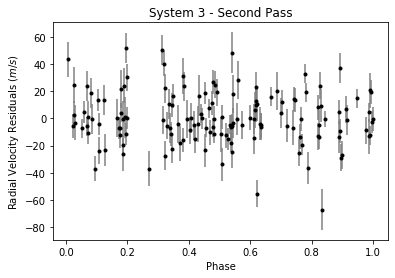

In [33]:
# Compute residuals
sys_3_fit = fit_sin(sys_3_phase_model, sys_3_vel_model)
sys_3_residuals = system_3['vel'] - sys_3_fit(sys_3_phase.value)
plt.errorbar(sys_3_phase, sys_3_residuals, system_3['unc'], fmt='.k', ecolor='grey')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity Residuals ($m/s$)')
plt.title('System 3 - Second Pass')
plt.savefig('sys_3/sys_3_2.pdf')

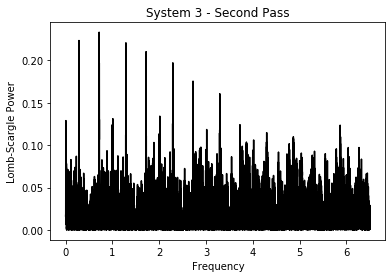

In [34]:
# Compute the Lomb-Scargle periodogram of the residuals and plot
sys_3_2_ls = LombScargle(system_3['date'], sys_3_residuals, system_3['unc'])
sys_3_2_freq, sys_3_2_power = sys_3_2_ls.autopower(nyquist_factor=100)
plt.plot(sys_3_2_freq, sys_3_2_power, color='k')
plt.xlabel('Frequency')
plt.ylabel('Lomb-Scargle Power')
plt.title('System 3 - Second Pass')
plt.savefig('sys_3/sys_3_2_ls.pdf')

In [35]:
# Determine the false alarm probability of the second periodogram maximum
sys_3_2_false_alarm_prob = sys_3_2_ls.false_alarm_probability(sys_3_2_power.max(), method='bootstrap')
print('Under the assumption that there is no periodic signal in the data, we will observe a peak at {:.2f} or above approximately {}% of the time.'.format(sys_3_2_power.max(), sys_3_2_false_alarm_prob*100))

Under the assumption that there is no periodic signal in the data, we will observe a peak at 0.23 or above approximately 0.0% of the time.


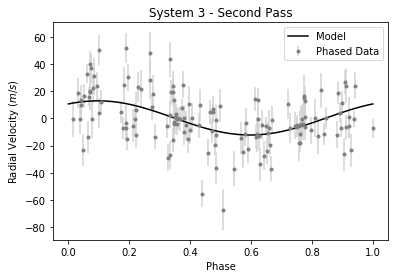

In [36]:
# Compute the best fit sinusoid of the residual
sys_3_2_period_days = 1 / sys_3_2_freq
sys_3_2_best_period = sys_3_2_period_days[np.argmax(sys_3_2_power)]
sys_3_2_phase = (system_3['date'] / sys_3_2_best_period) % 1
plt.errorbar(sys_3_2_phase, sys_3_residuals, system_3['unc'], fmt='.', color='grey', ecolor='lightgrey', label='Phased Data')

sys_3_2_phase_model = np.linspace(0, 1)
sys_3_2_best_frequency = sys_3_2_freq[np.argmax(sys_3_2_power)]
sys_3_2_vel_model = sys_3_2_ls.model(sys_3_2_phase_model / sys_3_2_best_frequency, sys_3_2_best_frequency)
plt.plot(sys_3_2_phase_model, sys_3_2_vel_model, color='k', label='Model')

plt.xlabel('Phase')
plt.ylabel('Radial Velocity ($m/s$)')
plt.title('System 3 - Second Pass')
plt.legend()
plt.savefig('sys_3/sys_3_2_phase_plot.pdf')

In [37]:
print('The second best period for System 3 is {:.2f} days.'.format(sys_3_2_best_period))

The second best period for System 3 is 1.40 days.
